In [6]:
import numpy as np
import scipy
import scipy.stats

import statsmodels.sandbox.stats.runs
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import _zconfint_generic
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 0. Загрузка данных

In [7]:
df = pd.read_csv('credit_card_default_analysis.csv',sep=',')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
## Разбиваем данные о кредитном лимите на две группы: вернувшие (df0) и не вернувшие (df1) кредит
df0 = df[df['default']==0] ## плательщики
df1 = df[df['default']==1] ## неплательщики

# 1. Размер кредитного лимита

In [9]:
## Разбивка данных для удобства
df0_lb = df0['LIMIT_BAL'] ## плательщики
df1_lb = df1['LIMIT_BAL'] ## неплательщики

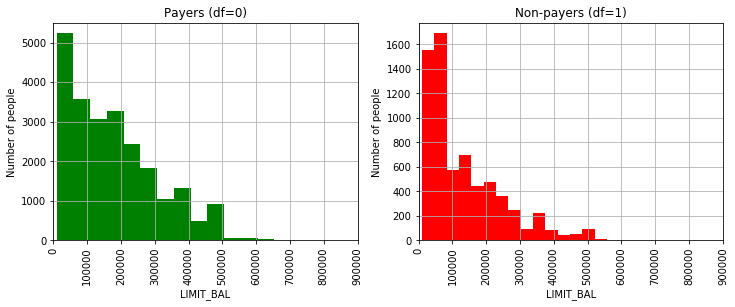

In [10]:
## Строим распределения значений кредитных лимитов в двух группах
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(df0_lb, color = 'g',bins=20)
plt.title('Payers (df=0)')
plt.xlabel('LIMIT_BAL')
plt.ylabel('Number of people')
plt.xlim(0,900000)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)


plt.subplot(1,2,2)
plt.grid()
plt.hist(df1_lb, color = 'r',bins=20)
plt.title('Non-payers (df=1)')
plt.xlabel('LIMIT_BAL')
plt.ylabel('Number of people')
plt.xlim(0,900000)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)


plt.show()

Из графиков выше видно, что распределения значений лимитов различаются в подвыборках плательщиков и неплательщиков. Видно, что в подвыборке плательщиков (df=0), больше больших значений лимитов, тогда как в подвыборке неплательщиков (df=1) наблюдается концентрация малых значений.


### a) Интервальная оценка медиан распределений и их разностей в подгруппах

Проведем оценку 95%-ых доверительных интервалов для медиан двух подвыборок (кредитных лимитов плательщиков и неплательщиков) и для разности медиан с помощью бутстрепа. Метод бутстрепа выбираем, поскольку метод подходит для распределений, не являющихся нормальными (наш случай).

In [11]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [12]:
# Бутстреп

v0 = df0_lb.values
v1 = df1_lb.values

v0_median_scores = map(np.median, get_bootstrap_samples(v0, 1000))
v1_median_scores = map(np.median, get_bootstrap_samples(v1, 1000))

print 'Точечная оценка для выборочной медианы v0 (плательщики): %8.1f' % np.median(v0)
print 'Точечная оценка для выборочной медианы v1 (неплательщики): %8.1f' % np.median(v1)

l,r = stat_intervals(v0_median_scores, 0.05)
print '95%% доверительный интервал для v0 (плательщики): медиана=[%8.1f %8.1f] ' % (l,r)
l,r = stat_intervals(v1_median_scores, 0.05)
print '95%% доверительный интервал для v1 (неплательщики): медиана=[%8.1f %8.1f] ' % (l,r)

delta_median_scores = map(lambda x: x[1] - x[0], zip(v0_median_scores,v1_median_scores))
l,r = stat_intervals(delta_median_scores, 0.05)
print '95%% доверительный интервал для разности медиан=[%8.1f %8.1f] ' % (l,r)


Точечная оценка для выборочной медианы v0 (плательщики): 150000.0
Точечная оценка для выборочной медианы v1 (неплательщики):  90000.0
95% доверительный интервал для v0 (плательщики): медиана=[150000.0 150000.0] 
95% доверительный интервал для v1 (неплательщики): медиана=[ 80000.0  90000.0] 
95% доверительный интервал для разности медиан=[-70000.0 -60000.0] 


Итак, 95% доверительные интервалы для медиан не пересекаются, а интервал для разности медиан - не содержит нуля. Это говорит о том, что медианы в двух подвыборках отличаются. В частности, подвыборка вернувших кредит содержит больше больших значений лимита.

### b) Проверка гипотезы о равенстве распределений с помощью перестановочного критерия 

Поскольку требуется проверить гипотезу о равенстве между собой функций распределения (причем неизвестных) двух независимых подвыборок (кредитных лимитов плательщиков и неплательщиков), применим перестановочный критерий для независимых выборок.
Нулевая гипотеза состоит в том, что функции распределения равны. Альтернативная гипотеза состоит в том что они не равны, причем вторая получается из первой сдвигом в любую из сторон.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [13]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr


def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [14]:
%%time
print "p-value: %f" % permutation_test(df0_lb, df1_lb, max_permutations = 10000)

p-value: 0.000100
Wall time: 38.2 s


Итак, получен достигаемый уровень значимости p=0.0001, что позволяет уверенно отвергнуть нулевую гипотезу о равенстве функций распределения в подвыборках на уровне значимости 0.05. 
Полученные результаты значимы с практической точки зрения - средний лимит плательщиков почти в 2 раза больше лимита неплательщиков.

# 2. Пол клиента

In [15]:
## Разбивка данных для удобства
df0_s = df0['SEX'] ## плательщики
df1_s = df1['SEX'] ## неплательщики

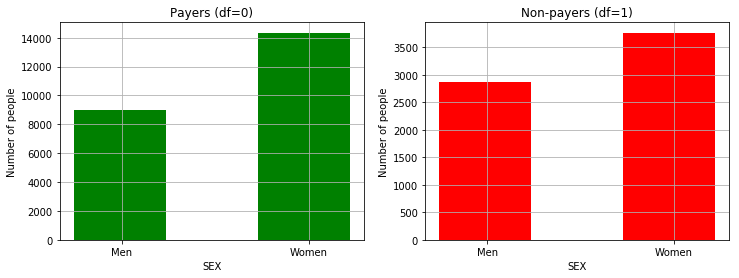

In [16]:
## Строим распределения полов клиентов в двух группах
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(df0_s-1, color = 'g',bins=3)
plt.title('Payers (df=0)')
plt.xlabel('SEX')
plt.ylabel('Number of people')
plt.xticks([ 0.175,0.85], ('Men', 'Women'))


plt.subplot(1,2,2)
plt.grid()
plt.hist(df1_s-1, color = 'r',bins=3)
plt.title('Non-payers (df=1)')
plt.xlabel('SEX')
plt.ylabel('Number of people')
plt.xticks([ 0.175,0.85], ('Men', 'Women'))


plt.show()

Данные графики показывают, что гендерный состав двух подвыборок в целом схож (женщин больше чем мужчин, эту разницу подвыборки наследуют из общей совокупности), однако в плательщиках доля женщин немного выше (последующие графики более наглядно демонстрируют масштаб разницы). Численно, разность в долях женщин следующая:

In [17]:
fraction_girls_d0 = (df0_s==2).sum()*1.0/df0_s.shape[0]
fraction_girls_d1 = (df1_s==2).sum()*1.0/df1_s.shape[0]

print 'Доля женщин в плательщиках = %4.2f' % fraction_girls_d0
print 'Доля женщин в неплательщиках = %4.2f' % fraction_girls_d1

Доля женщин в плательщиках = 0.61
Доля женщин в неплательщиках = 0.57


Проведем интервальные оценки для долей женщин в двух группах. Метод proportion_confint реализует расчет доверительного интервала для выборок с биномиальным распределением, поэтому нам подходит (вариант Вилсона точнее нормального, но при больших выборках это и не важно).

In [18]:
m0 = sum(df0_s-1)   # число женщин в группе плательщиков (df=0)
n0 = df0_s.shape[0] # общая численность группы плательщиков (df=0)
m1 = sum(df1_s-1)   # число женщин в группе неплательщиков (df=1)
n1 = df1_s.shape[0] # общая численность группы неплательщиков (df=1)

conf_interval_girls_d0 = proportion_confint(m0,n0,method = 'wilson')
conf_interval_girls_d1 = proportion_confint(m1,n1,method = 'wilson')
print '95%% доверительный интервал для доли женщин в плательщиках=[%4.3f, %4.3f]' % conf_interval_girls_d0
print '95%% доверительный интервал для доли женщин в неплательщиках=[%4.3f, %4.3f]' % conf_interval_girls_d1

95% доверительный интервал для доли женщин в плательщиках=[0.608, 0.620]
95% доверительный интервал для доли женщин в неплательщиках=[0.555, 0.579]


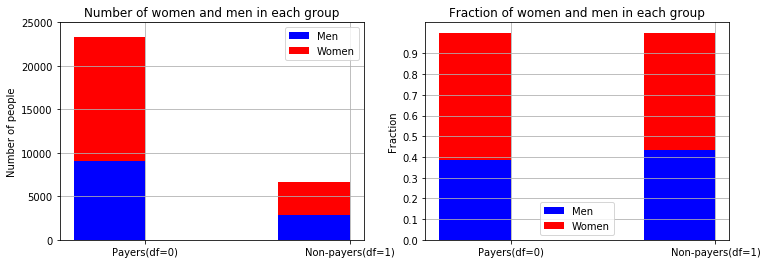

In [19]:
### Визуализация разницы численности и долей мужчин и женщин в двух группах

w0 = sum(df0_s-1)    # число женщин в группе плательщиков (df=0) 
n0 = df0_s.shape[0]  # общая численность группы плательщиков (df=0)
m0=n0-w0             # число мужчин в группе плательщиков (df=0) 
w1 = sum(df1_s-1)    # число женщин в группе неплательщиков (df=1)
n1 = df1_s.shape[0]  # общая численность группы неплательщиков (df=1)
m1=n1-w1             # число мужчин в группе неплательщиков (df=1) 

p0=m0*1.0/n0
p1=m1*1.0/n1

N = 2
ind = np.arange(N)
width = 0.35


plt.figure(figsize=(12,4))


## График распределения численности женщин и мужчин
plt.subplot(1,2,1)
plt.grid()

men = (m0, m1)
women = (w0, w1)

pl1 = plt.bar(ind, men, width, color='b')
pl2 = plt.bar(ind, women, width, color='r',bottom=men)

plt.ylabel('Number of people')
plt.title('Number of women and men in each group')
plt.xticks(ind + width/2., ('Payers(df=0)', 'Non-payers(df=1)'))
plt.yticks(np.arange(0, n0+n1, 5000))
plt.legend((pl1[0], pl2[0]), ('Men', 'Women'))


## График распределения долей женщин и мужчин
plt.subplot(1,2,2)
plt.grid()

men = (p0, p1)
women = (1-p0, 1-p1)

pl1 = plt.bar(ind, men, width, color='b')
pl2 = plt.bar(ind, women, width, color='r',bottom=men)

plt.ylabel('Fraction')
plt.title('Fraction of women and men in each group')
plt.xticks(ind + width/2., ('Payers(df=0)', 'Non-payers(df=1)'))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend((pl1[0], pl2[0]), ('Men', 'Women'))


plt.show()

Графики показывают что доля женщин в двух группах отличается, однако на малую величину в долях (см. в частности график справа).

Получим теперь интервальную оценку разницы долей женщин в двух группах

In [20]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [21]:
print 'Разница долей женщин в плательщиках и неплательщиках=%4.3f' % (fraction_girls_d0-fraction_girls_d1)
print '95%% доверительный интервал для разницы долей женщин в двух группах=[%4.3f, %4.3f]' %\
proportions_diff_confint_ind(df0_s-1, df1_s-1)      

Разница долей женщин в плательщиках и неплательщиках=0.047
95% доверительный интервал для разницы долей женщин в двух группах=[0.034, 0.061]


Проверим гипотезу о том, что доли женщин в двух группах не отличаются против двусторонней гипотезы о том, что они не равны. Итак, нулевая гипотеза: p1=p2 (доли женщин равны), двусторонняя альтернатива - не равны.

При справедливости нулевой гипотезы величина стоящая после слова return в функции proportions_diff_z_stat_ind выше распределена нормально (при большом n тем более). Поэтому применима Z статистика. 

Итак, проверку нулевой гипотезы проведем с помощью Z критерия для 2 независимых выборок случайных величин, распределеных по биномиальному закону.

In [22]:
print "p-value = %20.18f" %\
proportions_diff_z_test(proportions_diff_z_stat_ind(df0_s-1, df1_s-1),alternative = 'two-sided')

p-value = 0.000000000004472867


Итак, получен достигаемый уровень значимости, значительно меньший значения 0.05, что позволяет нам уверенно отвергнуть (на уровне значимости 0.05) нулевую гипотезу о равенстве долей женщин в двух подвыборках. 

Интервальные оценки показали, что 95% доверительные интервалы для долей женщин в подвыборках не пересекаются, а интервал их разности не содержит нуля, что говорит о различии долей в подвыборках. С 95%-ой вероятностью разница в долях женщин в двух группах составляет 3-6%.

Как показатель, результат значим практически - несмотря на соотношение мужчин и женщин в целом, наследованное из генеральной совокупности (больще женщин в целом обращались за кредитами), в неплательщиках их доля ниже, что интуитивно и интерпретируемо. Однако, оценить практическую значимость разницы в 3-6% с коммерческой точки зрения в рамках этого задания сложно.

# 3. Образование

In [23]:
## Разбивка данных для удобства
df0_ed = df0['EDUCATION'] ## плательщики
df1_ed = df1['EDUCATION'] ## неплательщики

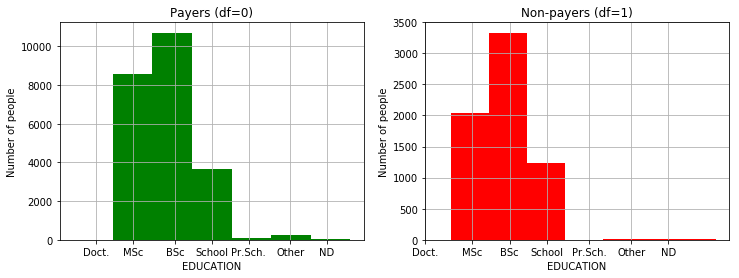

In [24]:
## Строим распределения видов образования в двух группах

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(df0_ed, color = 'g',bins=7)
plt.title('Payers (df=0)')
plt.xlabel('EDUCATION')
plt.ylabel('Number of people')
plt.xticks([0.5,1.3,2.2,3,3.8,4.7,5.5], ('Doct.','MSc','BSc','School','Pr.Sch.','Other','ND'))


plt.subplot(1,2,2)
plt.grid()
plt.hist(df1_ed, color = 'r',bins=7)
plt.title('Non-payers (df=1)')
plt.xlabel('EDUCATION')
plt.ylabel('Number of people')
plt.xticks([0.5,1.4,2.1,2.8,3.6,4.4,5.1], ('Doct.','MSc','BSc','School','Pr.Sch.','Other','ND'))

plt.show()

Данные графики показывают, что распределения по образованию в данных группах имеют некоторую схожесть, наследованную от общей совокупности. Однако, различия тоже наблюдаются: среди неплательщиков нет докторов, далее, доля бакалавров среди неплательщиков также выше их доли среди плательщиков.

In [25]:
## Для дальнейших вычислений определим состав признака в общей выборке
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

In [26]:
## Составим таблицу сопряженности
t = np.zeros((2,7),dtype='int')

for i in range(7):
    t[0,i] = np.sum(df0['EDUCATION']==i)
for i in range(7):
    t[1,i] = np.sum(df1['EDUCATION']==i)

Далее приводится визуализация таблицы сопряженности.

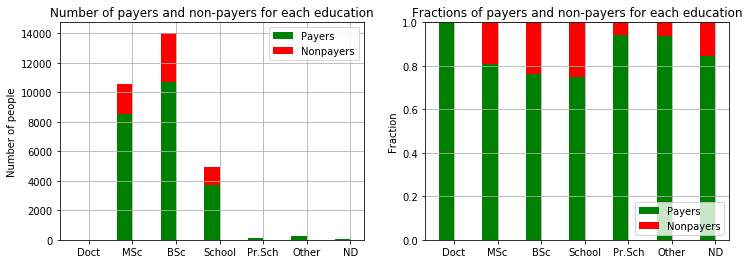

In [27]:
## Визуализация

# Число людей с каждым из образований в общей выборке
m = np.zeros(7)
for i in range(m.shape[0]):
    m[i] = np.sum(df['EDUCATION']==i)
    
m0 = t[0,:] # Число людей с каждым из образований среди плательщиков
m1 = t[1,:] # Число людей с каждым из образований среди неплательщиков

plt.figure(figsize=(12,4))
N = 7
ind = np.arange(N)
width = 0.35

plt.subplot(1,2,1)
plt.grid()

pl1 = plt.bar(ind, m0, width, color='g')
pl2 = plt.bar(ind, m1, width, color='r',bottom=m0)


plt.ylabel('Number of people')
plt.title('Number of payers and non-payers for each education')
plt.xticks(ind + width/2., ('Doct','MSc', 'BSc','School','Pr.Sch','Other','ND'))
plt.legend((pl1[0], pl2[0]), ('Payers', 'Nonpayers'))


plt.subplot(1,2,2)
plt.grid()

m0f = m0*1.0/m # Доля людей с каждым из образований среди плательщиков
m1f = m1*1.0/m # Доля людей с каждым из образований среди неплательщиков

pl1 = plt.bar(ind, m0f, width, color='g')
pl2 = plt.bar(ind, m1f, width, color='r',bottom=m0f)


plt.ylabel('Fraction')
plt.title('Fractions of payers and non-payers for each education')
plt.xticks(ind + width/2., ('Doct','MSc', 'BSc','School','Pr.Sch','Other','ND'))
plt.legend((pl1[0], pl2[0]), ('Payers', 'Nonpayers'),loc=4)

plt.show()

Поскольку число клиентов из группы {доктор, нач. школа, другое, нет данных} не только значительно меньше числа клиентов из группы {магистр, бакалавр и выпускник школы}, но и мало абсолютно, имеет смысл рассмотреть вторую группу отдельно, а вторую отбросить как шумовую. Это сделано в следующей визуализации:

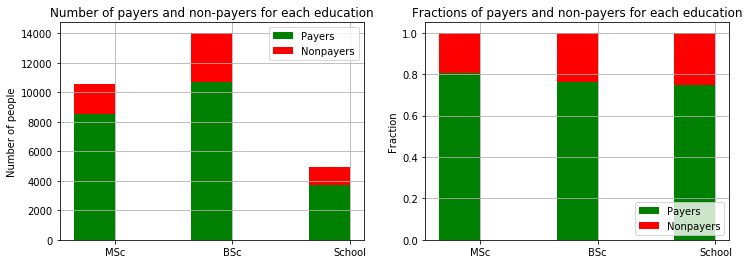

In [28]:
## Визуализация - только многочисленные группы

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.grid()
N = 3
ind = np.arange(N)

pl1 = plt.bar(ind, m0[1:4], width, color='g')
pl2 = plt.bar(ind, m1[1:4], width, color='r',bottom=m0[1:4])

plt.ylabel('Number of people')
plt.title('Number of payers and non-payers for each education')
plt.xticks(ind + width/2., ('MSc', 'BSc','School'))
plt.legend((pl1[0], pl2[0]), ('Payers', 'Nonpayers'))


plt.subplot(1,2,2)
plt.grid()

pl1 = plt.bar(ind, m0f[1:4], width, color='g')
pl2 = plt.bar(ind, m1f[1:4], width, color='r',bottom=m0f[1:4])

plt.ylabel('Fraction')
plt.title('Fractions of payers and non-payers for each education')
plt.xticks(ind + width/2., ('MSc', 'BSc','School'))
plt.legend((pl1[0], pl2[0]), ('Payers', 'Nonpayers'),loc=4)

plt.show()

Данные графики показывают, что доля неплательщиков растет с падением "уровня" образования. 

В следующем разделе будет проанализирована таблица сопряженности, наблюденные значения ячеек таблицы будут сравнены с ожидаемыми. Кроме этого, мы проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг, 

т.е. проверим нулевую гипотезу о том, что признаки "deafult" и "EDUCATION" связаны против общей альтернативы
что они не связаны. 

Для этого применим критерий Хи квадрат для категориальных признаков.

In [29]:
n = df.shape[0]
print 'n =',n

n = 30000


Применимость критерия Хи квадрат установим следующим образом. Первое требование, о том, что n>40 заведомо выполняется, т.к. размер выборки=30000.

Второе требование о том, что доля ячеек с ожидаемым количеством элементов меньше 5 была не более 20% мы проверим после вычисления ожидаемой таблицы сопряженности. Таблица 2 ниже показывает что в нашем случае есть одна такая ячейка (со значением 3), т.е. это 7%. 

Критерий Хи квадрат применим.

In [30]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(t)
print 'Критерий Хи квадрат:\nстатистика =',chi2,'     уровень значимости =', p


n0 = df0.shape[0]
n1 = df1.shape[0]
n = df.shape[0]
overall_default_rate = n1*100.0/n

print '\nДоля невозврата во всей выборке: %2.0f%% ' % overall_default_rate


    
print '\nТаблица 1. Наблюденная таблица сопряженности t.'
print '\t\t Доктор   Магистр  Бакалавр     Школа   Нач.шк.    Прочее   Нет данных'
for i in range(2):
    print 'default=%d    ' % i,
    for j in range(7):
        print "%9.0f" % t[i,j],
    print

print 'разница:     ',
for j in range(7):
    print '%9.0f' % (t[0,j]-t[1,j]),
print
print '% невозврата:',
for j in range(7):
    print '%9.0f' % (t[1,j]*100.0/(t[0,j]+t[1,j])),
print
print 'отклонение %:',
for j in range(7):
    print '%9.0f' % (t[1,j]*100.0/(t[0,j]+t[1,j])-overall_default_rate),
print '\n\n'    


print '\n\nТаблица 2. Ожидаемая таблица сопряженности t (значения округленны до целых).'
print '\t\t Доктор   Магистр  Бакалавр     Школа   Нач.шк.    Прочее   Нет данных'
for i in range(2):
    print 'default=%d    ' % i,
    for j in range(7):
        print "%9.0f" % ex[i,j],
    print

print '% невозврата:',
for j in range(7):
    print '%9.0f' % (ex[1,j]*100.0/(ex[0,j]+ex[1,j])),
print '\n\n\n'

Критерий Хи квадрат:
статистика = 163.21655786997073      уровень значимости = 1.2332626245415605e-32

Доля невозврата во всей выборке: 22% 

Таблица 1. Наблюденная таблица сопряженности t.
		 Доктор   Магистр  Бакалавр     Школа   Нач.шк.    Прочее   Нет данных
default=0            14      8549     10700      3680       116       262        43
default=1             0      2036      3330      1237         7        18         8
разница:             14      6513      7370      2443       109       244        35
% невозврата:         0        19        24        25         6         6        16
отклонение %:       -22        -3         2         3       -16       -16        -6 




Таблица 2. Ожидаемая таблица сопряженности t (значения округленны до целых).
		 Доктор   Магистр  Бакалавр     Школа   Нач.шк.    Прочее   Нет данных
default=0            11      8244     10927      3829        96       218        40
default=1             3      2341      3103      1088        27        62     

Уровень значимости для полученной статистики Хи квадрат (1.2e-32) значительно ниже 0.05, что позволяет уверенно отвергнуть гипотезу о том, что признаки независимы, т.е. нулевая гипотеза на уровне значимости 0.05 отвергается.

Проведем анализ наблюденной и ожидаемой таблиц сопряженности, т.е. соответственно таблица 1 и таблица 2 выше.
В первых двух строках таблицы 1 приведено число людей с разным образованием среди плательщиков (def=0) и неплательщиков (def=1). 
В третьей строке - разница числа вернувших и невернувших кредит для каждого из образований. 
В четвертой строке - процент невозврата для каждого из образований.
И наконец в пятой строке - отклонение процента невозврата для данного образования от общего процента невозврата (около 22%).

Ответ на вопрос задания о том, как привести значения разности вернувших и невернувших кредиты (строка 3 таблицы 1) к одному масштабу - нужно расчитать процент невозврата и отклонение от общего процента невозврата, как это и сделано в таблице 1 (строки 4 и 5).

То, как меняется процент невозврата и отклонение от общего процента, дополнительно проиллюстрировано на графиках ниже.

В частности, видно что выпускники школ связаны с наибольшим невозвратом кредита, а доктора с наименьшим невозвратом. Если мы откинем докторов как слишком малочисленную выборку, то наилучшие плательщики - магистры.

Ожидаемая таблица 2 получена в результате применения критерия Хи квадрат, она содержит ожидаемые значения для независимых признаков. Как и ожидалось, ожидаемый процент невозврата в таблице составляет около 22%.

Практическая значимость (в коммерческом плане) наблюдаемой зависимости возврата кредита от образования скорее всего ограничена, т.к. отклонение от среднего в пределах 3 процентов (для многочисленных групп). Как показатель-же этот результат интуитивен и хорошо интерпретируем.

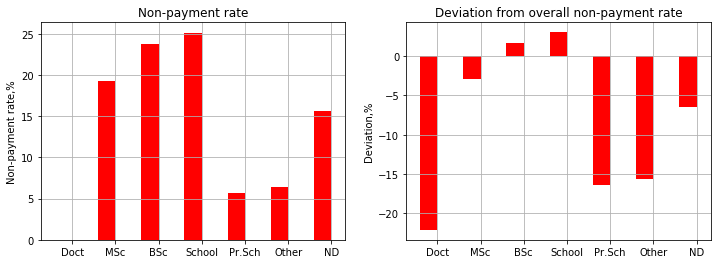

In [31]:
nonpayment = t[1,:]*100.0/(t[0,:]+t[1,:])
deviations = t[1,:]*100.0/(t[0,:]+t[1,:])-overall_default_rate

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.grid()
ind = np.arange(7)
width = 0.4
plt.bar(ind, nonpayment, width, color='r')
plt.ylabel('Non-payment rate,%')
plt.title('Non-payment rate')
plt.xticks(ind + width/2., ('Doct','MSc', 'BSc','School','Pr.Sch','Other','ND'))

plt.subplot(1,2,2)
plt.grid()
plt.bar(ind, deviations, width, color='r')
plt.ylabel('Deviation,%')
plt.title('Deviation from overall non-payment rate')
plt.xticks(ind + width/2., ('Doct','MSc', 'BSc','School','Pr.Sch','Other','ND'))


plt.show()

Графики показывают, что процент невозврата кредита растет с падением уровня образования (если не брать в расчет малочисленне признаки нач. школа, другое и нет данных). Кроме того, график справа показывает, что процент невозврата бакалавров и выпускников школ выше среднего, тогда как магистров - ниже (малочисленные опять не смотрим).

# 4. Семейное положение

In [32]:
## Разбивка данных для удобства
df0_m = df0['MARRIAGE'] ## плательщики
df1_m = df1['MARRIAGE'] ## неплательщики

In [33]:
## состав признака
df0_m.unique()

array([2, 1, 3, 0], dtype=int64)

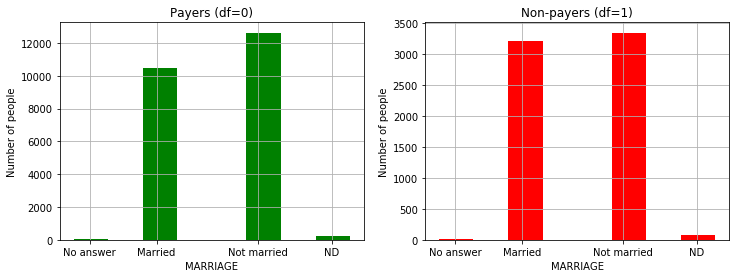

In [34]:
## Строим распределения полов клиентов в двух группах
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(df0_m, color = 'g',bins=8)
plt.title('Payers (df=0)')
plt.xlabel('MARRIAGE')
plt.ylabel('Number of people')
plt.xticks([ 0.175,0.9, 2.0, 2.8], ('No answer', 'Married', 'Not married', 'ND'))


plt.subplot(1,2,2)
plt.grid()
plt.hist(df1_m, color = 'r',bins=8)
plt.title('Non-payers (df=1)')
plt.xlabel('MARRIAGE')
plt.ylabel('Number of people')
plt.xticks([ 0.175,0.9, 2.0, 2.8], ('No answer', 'Married', 'Not married', 'ND'))


plt.show()

Очевидно что значения признака "Нет ответа" и "Нет данных" малочислены и не несут информации - удаляем их из дальнейшего рассмотрения.

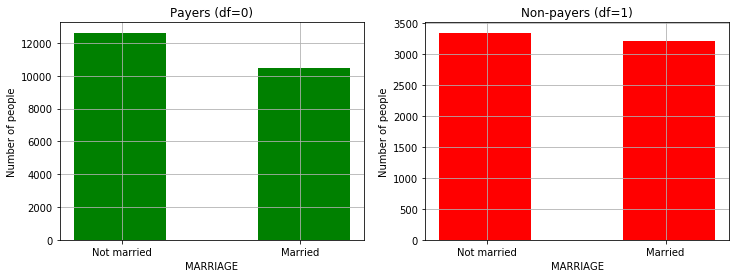

In [35]:
## Поменяем обозначения
df0_m = df0['MARRIAGE']
df1_m = df1['MARRIAGE']
df0_m = df0_m[(df0_m==1)|(df0_m==2)]-2
df1_m = df1_m[(df1_m==1)|(df1_m==2)]-2
df0_m = df0_m**2
df1_m = df1_m**2
#теперь:
# 0 - не в браке
# 1 - в браке
plt.figure(figsize=(12,4))



plt.subplot(1,2,1)
plt.grid()
plt.hist(df0_m, color = 'g',bins=3)
plt.title('Payers (df=0)')
plt.xlabel('MARRIAGE')
plt.ylabel('Number of people')
plt.xticks([ 0.175,0.82], ('Not married', 'Married'))


plt.subplot(1,2,2)
plt.grid()
plt.hist(df1_m, color = 'r',bins=3)
plt.title('Non-payers (df=1)')
plt.xlabel('MARRIAGE')
plt.ylabel('Number of people')
plt.xticks([ 0.175,0.82], ('Not married', 'Married'))


plt.show()

Судя по графикам, доля холостых больше среди плательщиков, тогда как среди неплательщиков доли холостых и женатых(замужних) примерно равны.

Составим таблицу сопряженности для признаков "default" и "MARRIAGE" и визуализируем ее.

In [36]:
t = np.zeros((2,2),dtype='int')

t[0,0] = np.sum(df0['MARRIAGE']==2) # default=0,married=0 - холостые плательщики
t[0,1] = np.sum(df0['MARRIAGE']==1) # default=0,married=1 - плательщики в браке
t[1,0] = np.sum(df1['MARRIAGE']==2) # default=1,married=0 - холостые неплательщики
t[1,1] = np.sum(df1['MARRIAGE']==1) # default=1,married=1 - неплательщики в браке

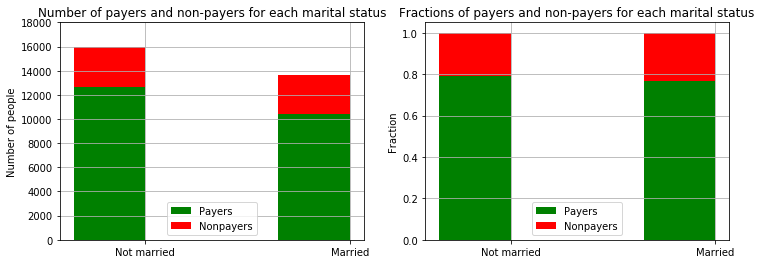

In [37]:
## Визуализация

m = np.zeros(2)
m[0] = np.sum(df['MARRIAGE']==2) ## общее число холостых
m[1] = np.sum(df['MARRIAGE']==1) ## общее число людей в браке

m0 = t[0,:] # Число холостых и в браке среди плательщиков
m1 = t[1,:] # Число холостых и в браке среди неплательщиков

plt.figure(figsize=(12,4))
N = 2
ind = np.arange(N)
width = 0.35

plt.subplot(1,2,1)
plt.grid()

pl1 = plt.bar(ind, m0, width, color='g')
pl2 = plt.bar(ind, m1, width, color='r',bottom=m0)


plt.ylabel('Number of people')
plt.title('Number of payers and non-payers for each marital status')
plt.xticks(ind + width/2., ('Not married','Married'))
plt.ylim(0,18000)
plt.legend((pl1[0], pl2[0]), ('Payers', 'Nonpayers'),loc=8)


plt.subplot(1,2,2)
plt.grid()

m0f = m0*1.0/m # Доли холостых и в браке среди плательщиков
m1f = m1*1.0/m # Доли холостых и в браке среди неплательщиков

pl1 = plt.bar(ind, m0f, width, color='g')
pl2 = plt.bar(ind, m1f, width, color='r',bottom=m0f)


plt.ylabel('Fraction')
plt.title('Fractions of payers and non-payers for each marital status')
plt.xticks(ind + width/2., ('Not married','Married'))
plt.legend((pl1[0], pl2[0]), ('Payers', 'Nonpayers'),loc=8)

plt.show()

Графики показывают что доля неплательщиков несколько больше среди женатых/замужних клиентов - в частности это видно по графику справа. 

В следующем разделе будет проанализирована таблица сопряженности, наблюденные значения ячеек таблицы будут сравнены с ожидаемыми. Кроме этого, мы проверим гипотезу о том, что семейное положение не влияет на то, вернет ли человек долг, 

т.е. проверим нулевую гипотезу о том, что признаки "deafult" и "MARRIAGE" связаны против общей альтернативы что они не связаны. 

Для этого применим критерий Хи квадрат.

Аналогично предыдущему заданию, применимость критерия Хи квадрат установим следующим образом. Первое требование, о том, что n>40 заведомо выполняется, т.к. размер выборки=30000.

Второе требование о том, что доля ячеек с ожидаемым количеством элементов меньше 5 была не более 20% мы проверим после вычисления ожидаемой таблицы сопряженности. Таблица 2 ниже показывает что в нашем случае таких ячеек нет.

Итак, критерий Хи квадрат применим.

In [33]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(t)
print 'Критерий Хи квадрат:\nстатистика =',chi2,'     уровень значимости =', p

print '\nДоля невозврата во всей выборке: %2.0f%% ' % overall_default_rate


print '\n\nТаблица 1. Наблюденная таблица сопряженности t.'
print '\t       Холостые   В браке'
for i in range(2):
    print 'default=%d    ' % i,
    for j in range(2):
        print "%9.0f" % t[i,j],
    print

print 'разница:     ',
for j in range(2):
    print '%9.0f' % (t[0,j]-t[1,j]),
print
print '% невозврата:',
for j in range(2):
    print '%9.0f' % (t[1,j]*100.0/(t[0,j]+t[1,j])),
print
print 'отклонение %:',
for j in range(2):
    print '%9.0f' % (t[1,j]*100.0/(t[0,j]+t[1,j])-overall_default_rate),
print '\n\n'    


print '\nТаблица 2. Ожидаемая таблица сопряженности t (значения округленны до целых).'
print '\t       Холостые   В браке'
for i in range(2):
    print 'default=%d    ' % i,
    for j in range(2):
        print "%9.0f" % ex[i,j],
    print

print '% невозврата:',
for j in range(2):
    print '%9.0f' % (ex[1,j]*100.0/(ex[0,j]+ex[1,j])),
print '\n\n\n'




Критерий Хи квадрат:
статистика = 27.509409093      уровень значимости = 1.5633210356e-07

Доля невозврата во всей выборке: 22% 


Таблица 1. Наблюденная таблица сопряженности t.
	       Холостые   В браке
default=0         12623     10453
default=1          3341      3206
разница:           9282      7247
% невозврата:        21        23
отклонение %:        -1         1 



Таблица 2. Ожидаемая таблица сопряженности t (значения округленны до целых).
	       Холостые   В браке
default=0         12436     10640
default=1          3528      3019
% невозврата:        22        22 





Уровень значимости для полученной статистики Хи квадрат (1.6e-7) значительно ниже 0.05, что позволяет уверенно отвергнуть гипотезу о том, что признаки независимы, т.е. нулевая гипотеза на уровне значимости 0.05 отвергается.

Таблица 1 показывает число людей с различным семейным положением вернувших и не вернувших кредиты (строки 1-2). В третьей строке приведена разница между плательщиками и неплательщиками в зависимости от семейного положения.
В четвертой строке - процент невозврата, в пятой строке - отклонение процента невозврата от общего процента невозврата (около 22%).
По таблице 1 видно, что семейное положение меньше влияет на возврат кредита, чем например образование (см. таблицу 1 раздела 3). Отклонение от общего процента невозврата всего 1%. Практически это мало значимо.

Таблица 2 показывает ожидаемые значение в предположении что признаки не связаны. Как видно из строки 5 таблицы 1, наблюденный процент невозврата весьма близок к ожидаемому.


Мера взаимосвязи бинарных признаков "default" и "MARRIAGE" - это коэфициент корреляции Крамера, он рассчитывается ниже:

In [34]:
## Коэфициент корреляции Крамера
PHIc = np.sqrt(chi2/n)
print '\nКоэффициент корреляции Крамера PHIc=%3.2f' % PHIc


Коэффициент корреляции Крамера PHIc=0.03


Полученное значение коэфициент корреляции Крамера весьма мало, что согласуется со слабой связью семейного положения с возвратом кредита.

# 5. Возраст

In [35]:
## Разбивка данных для удобства
df0_a = df0['AGE'] ## плательщики
df1_a = df1['AGE'] ## неплательщики

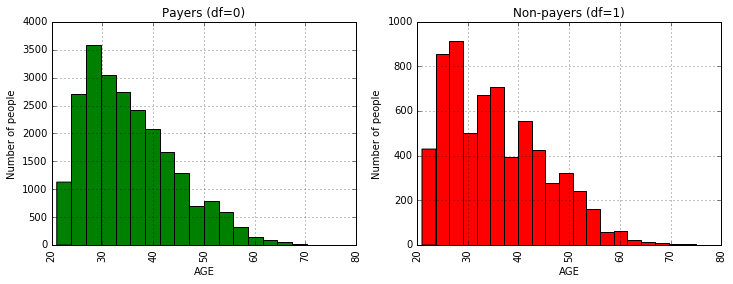

In [36]:
## Строим распределения значений кредитных лимитов в двух группах
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(df0_a, color = 'g',bins=20)
plt.title('Payers (df=0)')
plt.xlabel('AGE')
plt.ylabel('Number of people')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)


plt.subplot(1,2,2)
plt.grid()
plt.hist(df1_a, color = 'r',bins=20)
plt.title('Non-payers (df=1)')
plt.xlabel('AGE')
plt.ylabel('Number of people')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)


plt.show()

Графики показывают, что распределения возрастов в двух группах схожи, за исключением скорее локальных различий. По-видимому, мы, в основном, наблюдаем общий характер распределения по возрасту в двух подвыборках, наследованный из общей совокупности клиентов.


### a) Интервальная оценка медиан распределений и их разностей в подгруппах

Проведем оценку 95%-ых доверительных интервалов для медиан двух подвыборок (возрастов плательщиков и возрастов неплательщиков) и для разности медиан подвыборок с помощью бутстрепа. Метод бутстрепа выбираем, поскольку метод подходит для распределений, не являющихся нормальными (наш случай).

In [37]:
# Бутстреп

v0 = df0_a.values
v1 = df1_a.values

v0_median_scores = map(np.median, get_bootstrap_samples(v0, 1000))
v1_median_scores = map(np.median, get_bootstrap_samples(v1, 1000))

print 'Точечная оценка для выборочной медианы v0 (плательщики): %4.1f' % np.median(v0)
print 'Точечная оценка для выборочной медианы v1 (неплательщики): %4.1f' % np.median(v1)

l,r = stat_intervals(v0_median_scores, 0.05)
print '95%% доверительный интервал для v0 (плательщики): медиана=[%4.1f %4.1f] ' % (l,r)
l,r = stat_intervals(v1_median_scores, 0.05)
print '95%% доверительный интервал для v1 (неплательщики): медиана=[%4.1f %4.1f] ' % (l,r)

delta_median_scores = map(lambda x: x[1] - x[0], zip(v0_median_scores,v1_median_scores))
l,r = stat_intervals(delta_median_scores, 0.05)
print '95%% доверительный интервал для разности медиан=[%4.1f %4.1f] ' % (l,r)


Точечная оценка для выборочной медианы v0 (плательщики): 34.0
Точечная оценка для выборочной медианы v1 (неплательщики): 34.0
95% доверительный интервал для v0 (плательщики): медиана=[34.0 34.0] 
95% доверительный интервал для v1 (неплательщики): медиана=[34.0 35.0] 
95% доверительный интервал для разности медиан=[ 0.0  1.0] 


Итак, мы получили перекрывающиеся 95%-ые доверительные интервалы для оценок медиан двух подвыборок, а доверительный интервал для разности медиан содержит нуль. На основании этого мы не можем заключить, что медианы подвыборок различны.

### b) Проверка гипотезы о равенстве распределений с помощью рангового критерия Манна-Уитни

Проверим нулевую гипотезу о том, что функции распределений двух подвыборок (возрастов плательщиков и неплательщиков) равны против двусторонней альтернативы о том, что они не равны. 

Нулевая гипотеза состоит в том, что функции распределения равны. Альтернативная гипотеза состоит в том что они не равны, причем вторая получается из первой сдвигом в любую из сторон.

$H_0\colon F_{df_0}(x) = F_{df_1}(x)$

$H_1\colon F_{df_0}(x) = F_{df_1}(x + \Delta), \Delta\neq 0$

Проверку проведем с помощью рангового критерия Манна-Уитни для независимых выборок поскольку выборки возрастов плательщиков и неплательщиков независимы, их распределения неизвестны.

In [38]:
stats.mannwhitneyu(df0_a, df1_a, alternative='two-sided')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.37276989592390031)

Получен уровень значимости 0.37 => гипотезу $H_0$ на уровне 0.05 отвергнуть не можем.

Итак, данные не позволяют отвергнуть гипотезу о том, что возраст не влияет на возврат кредита.
Можно заключить, что также и практически, возрастная характеристика двух групп схожа и нет оснований судить о возврате/не возврате по одному лишь возрасту.